# Capstone Project

## Data Gathering

In [147]:
# Import libraries
from collections import Counter
from itertools import cycle
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
import pickle
from scipy import interp
import seaborn as sns
from sklearn import svm, neighbors, model_selection
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.svm import SVC

from nltk.classify.scikitlearn import SklearnClassifier

import warnings
warnings.filterwarnings("ignore")

In [148]:
# df_funda = pd.read_csv('./data/fundamentals.csv', index_col=0)

In [149]:
# df_prices = pd.read_csv('./data/prices.csv')

In [150]:
# Reading data from csv
df = pd.read_csv('./data/all_stocks_5yr.csv')

## Data exploration

In [151]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
date      619040 non-null object
open      619029 non-null float64
high      619032 non-null float64
low       619032 non-null float64
close     619040 non-null float64
volume    619040 non-null int64
Name      619040 non-null object
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB


In [153]:
# Checking for missing values

df.isnull().values.any()

True

In [154]:
df.shape

(619040, 7)

The data set contains 619 040 rows of data. Each row contains a set of prices for a certain stock ticker, for a certain day. I will be focusing on closing prices for each day, and ignore intra-day fluctations. To organize the data frame I will privot the dataframe using date as index, with one column for each stock ticker. 

In [155]:
df = df.pivot(index='date', columns='Name', values='close')

In [156]:
df.head()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2013-02-08,45.08,14.75,78.90,67.8542,36.25,46.89,34.41,73.31,39.12,45.70,...,28.24,37.51,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-11,44.60,14.46,78.39,68.5614,35.85,46.76,34.26,73.07,38.64,46.08,...,28.31,37.46,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,44.62,14.27,78.60,66.8428,35.42,46.96,34.30,73.37,38.89,46.27,...,28.41,37.58,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74
2013-02-13,44.75,14.66,78.97,66.7156,35.27,46.64,34.46,73.56,38.81,46.26,...,28.42,37.80,88.67,43.08,32.00,28.26,64.41,76.00,24.74,33.55
2013-02-14,44.58,13.99,78.84,66.6556,36.57,46.77,34.70,73.13,38.61,46.54,...,28.22,38.44,88.52,42.91,32.12,28.47,63.89,76.34,24.63,33.27


In [157]:
df.shape

(1259, 505)

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1259 entries, 2013-02-08 to 2018-02-07
Columns: 505 entries, A to ZTS
dtypes: float64(505)
memory usage: 4.9+ MB


In [159]:
df.describe()

Name,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.00000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,...,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,49.202025,38.393252,132.433463,109.066698,60.86444,82.092979,42.940326,101.119079,90.458156,60.931932,...,35.315099,49.833474,87.668447,53.821882,40.486807,41.434095,75.451009,105.606291,32.171790,45.098648
std,9.229804,10.957636,31.274463,30.556812,13.73038,16.315690,5.860169,22.129031,36.997773,13.383631,...,3.874693,9.517797,6.959475,7.599269,7.949466,11.319674,7.485003,15.052699,7.673401,11.981390
min,33.370000,13.020000,76.180000,55.789900,35.27000,46.180000,32.930000,70.280000,38.110000,42.340000,...,27.960000,35.510000,68.710000,40.240000,27.520000,24.190000,59.700000,72.380000,19.900000,28.400000
25%,41.560000,34.330000,104.440000,84.830650,52.65000,70.525000,38.475000,80.670000,65.865000,50.272500,...,32.175000,43.222500,82.435000,47.015000,34.400000,34.590000,70.225000,96.075000,27.505000,32.830000
50%,46.700000,40.870000,141.300000,109.010000,60.17000,82.560000,42.300000,97.770000,80.590000,56.930000,...,35.010000,46.860000,87.290000,53.540000,40.000000,37.280000,74.100000,105.970000,29.230000,45.620000
75%,56.495000,46.535000,156.730000,127.120000,65.74500,92.520000,45.785000,117.045000,105.710000,67.895000,...,37.770000,54.060000,92.085000,60.805000,45.480000,49.155000,80.470000,117.315000,32.462500,51.295000
max,74.820000,58.470000,200.380000,179.260000,123.21000,115.480000,63.420000,162.550000,201.300000,97.240000,...,46.660000,76.300000,104.380000,68.580000,57.280000,75.660000,94.880000,133.090000,54.980000,80.090000


In [160]:
def get_df():
    df = pd.read_csv('./data/all_stocks_5yr.csv')
    df = df.pivot(index='date', columns='Name', values='close')
    
    return df

## Visual exploration

In [161]:
def stock_visualization(ticker):
    '''
    Function for visualizing stock price over time.
    
    INPUT: ticker, string
    
    OUTPUT: plot of stock price over time
    '''
    fig,ax1 = plt.subplots(figsize=(10, 5))
    df[ticker].plot()
    plt.show()
    

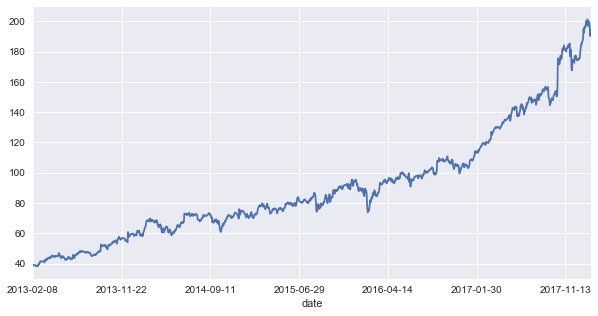

In [162]:
# Visualizing Adobe stock price development
stock_visualization('ADBE')

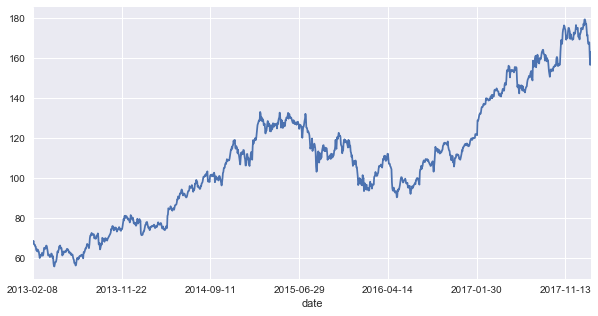

In [163]:
# Apple
stock_visualization('AAPL')

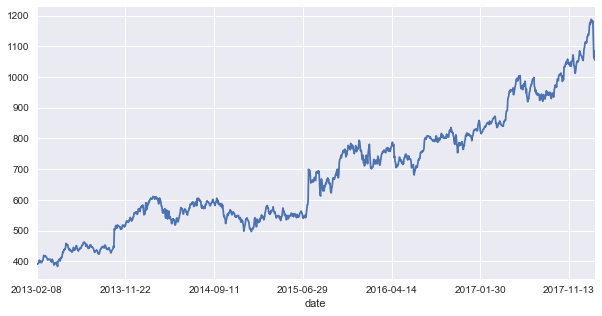

In [164]:
# Google
stock_visualization('GOOGL')

In [165]:
def stock_heatmap(df):
    '''
    The function takes a dataframe as input, gets the
    correlation between stocks and plots a heatmap of 
    stock price correlation.
    
    INPUT:
    df - dataframe 
    OUTPUT:
    heatmap of correlation
    '''
    
    df = df
    
    # Getting pairwise correlation of columns
    df_corr = df.corr()
    data = df_corr.values

    # Setting up heatmap of stock correlation
    ax = sns.heatmap(data, cmap='coolwarm')

    # Various adjustments and graph set-up
    ax.set_xticks(np.arange(data.shape[0]) + 0.5, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.5, minor=False)
    ax.xaxis.tick_top()

    column_labels = df_corr.columns
    row_labels = df_corr.index

    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    fig = ax.get_figure()
    plt.tight_layout()
    plt.show()
    fig.savefig('heatmap.png')
    

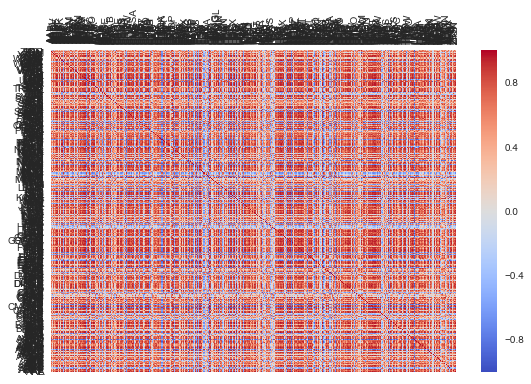

In [166]:
stock_heatmap(df)

## Data preprocessing

The heatmap reveals correlation between groups of companies. We know that stocks in general have tended to increase in value over time, but the heatmap reveals both positive and negative correlation, of different strength. If we infer from this that the price of groups of companies tend to move together, can we gain an edge by studying this relationship using machine learning? The assumption that certain companies move together makes a lot of sense. For instance, we expect the profits (and thus share price) of companies in the oil industry to be linked to the oil price, and we expect retail companies to linked to eg. the disposable income of consumers or the unemployment rate. There might also be relationships that are less obvious to a human, but might be revealed using machine learning. In most cases, we would not expect the stock prices to move simultaneously for all companies. Some companies will lead, some will lag. It is this relationship I want to study more closely, which might give us an edge in deciding whether to buy, sell or hold a certain stock.

Prepare data for analysis:
- Normalize data: Convert stock prices to percentage change. These changes will be our features, determining our labels (buy, sell, hold).
- Issue? We're training data on 5 years of data, checking correlation. Too long period might be a problem due to companies' relationships to changing over time
- On average, stocks increase over time. Is our strategy better than a simply buying? -> buy and  hold

In [167]:
def preprocessing_data(ticker):
    '''
    Function adds number_of_days amounts of columns
    containing percentage change in price for a stock.
    
    INPUT:
    ticker - stock ticker
    
    OUTPUT:
    tickers - list of stock tickers
    df - updated data frame with new columns
    '''
    # Period for measuring change
    number_of_days = 5
    
    df = get_df()
    
    tickers = df.columns.values.tolist()
    
    # Dealing with missing values
    df.fillna(0, inplace=True)
    
    for i in range(1, number_of_days + 1):
        df['{}_{}d'.format(ticker, i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]
        
    df.fillna(0, inplace=True)
    
    return tickers, df

In [189]:
def buy_sell_hold(*args):
    '''
    Function for labelling buy or hold
    based on price change in percent.
    
    Can be modified to include sell.
    '''
    # Passing number_of_days number of prices
    cols = [c for c in args]
    
    # Required change in price of number_of_days
    requirement = 0.02
    
    # If change > requirement, return 1 (buy),
    # if price down > negative requirement, return -1 (sell),
    # else 0 (hold)
    for col in cols:
        if col > requirement:
            return 1
        #if col < -requirement:
        #    return -1
    
    return 0

In [169]:
def get_features(ticker):
    '''
    Function for defining a new column in the data set,
    containing labels for buy, sell or hold, and getting
    sets of features and labels.
    
    INPUT:
    ticker - stock ticker
    
    OUTPUT:
    X - feature set, here percentage change in price
    y - labels (buy, sell, hold)
    df - updated data frame
    '''
    
    tickers, df = preprocessing_data(ticker)
    
    df['{}_target'.format(ticker)] = list(map(buy_sell_hold,
                                              df['{}_1d'.format(ticker)],
                                              df['{}_2d'.format(ticker)],
                                              df['{}_3d'.format(ticker)],
                                              df['{}_4d'.format(ticker)],
                                              df['{}_5d'.format(ticker)]))
    
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    
    # Print distribution of buy, sell, hold
    print('Data spread:', Counter(str_vals))
   
    # Handle any infinite changes in percentage, replace with NaN
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    
    # Dropping the NaNs
    df.dropna(inplace=True)
    
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    
    # Getting features
    X = df_vals.values
    
    # Getting labels
    y = df['{}_target'.format(ticker)].values
    
    return X, y, df

In [170]:
X, y, df = get_features('GOOGL')

Data spread: Counter({'0': 821, '1': 438})


In [171]:
df.GOOGL_target.value_counts()

0    821
1    438
Name: GOOGL_target, dtype: int64

## Implementation

In [172]:
def ml_svm(ticker):
    '''
    Baseline out-of-the-box SVM as a benchmark.
    
    INPUT:
    ticker - stock price ticker
    
    OUTPUT:
    Data spread, accuracy, prediction spread
    '''
    X, y, df = get_features(ticker)
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size = 0.2)

    clf = svm.LinearSVC()
    #clf = SVC(probability=True)
    
    clf.fit(X_train, y_train)
    
    confidence = clf.score(X_test, y_test)
    print('Accuracy:', confidence)
    
    predictions = clf.predict(X_test)
    print('Predicted spread:', Counter(predictions))
    
    return clf, predictions, X_train, X_test, y_train, y_test

In [173]:
def ml_vote(ticker):
    '''
    Voting on three different classifiers:
    k-nearest neighors, linear svc and random forest.
    
    INPUT:
    ticker - stock price ticker
    
    OUTPUT:
    Data spread, accuracy, prediction spread
    '''
    X, y, df = get_features(ticker)
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size = 0.2)
    
    clf_A = neighbors.KNeighborsClassifier()
    clf_B = svm.LinearSVC()
    clf_C = RandomForestClassifier()

    clf = VotingClassifier(estimators=[('knn', clf_A), 
                                       ('lsvc', clf_B), 
                                       ('rf', clf_C)], voting='hard')
    clf.fit(X_train, y_train)
    
    confidence = clf.score(X_test, y_test)
    print('Accuracy:', confidence)
    
    predictions = clf.predict(X_test)
    print('Predicted spread:', Counter(predictions))
    
    return

In [174]:
def ml_rf(ticker):
    '''
    Voting on three different classifiers:
    k-nearest neighors, linear svc and random forest.
    
    INPUT:
    ticker - stock price ticker
    
    OUTPUT:
    Data spread, accuracy, prediction spread
    '''
    X, y, df = get_features(ticker)
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size = 0.2)
    
    clf = RandomForestClassifier()

    clf.fit(X_train, y_train)
    
    confidence = clf.score(X_test, y_test)
    print('Accuracy:', confidence)
    
    predictions = clf.predict(X_test)
    print('Predicted spread:', Counter(predictions))
    
    return clf, predictions, X_train, X_test, y_train, y_test

#### Support Vector Machine

In [175]:
model, predictions, X_train, X_test, y_train, y_test = ml_svm('BAC')

Data spread: Counter({'0': 760, '1': 499})
Accuracy: 0.607142857143
Predicted spread: Counter({0: 227, 1: 25})


In [176]:
def save_model(model, model_filepath):
    """
    Function for saving the model.

    INPUT:
    model - model to be saved
    model_filpath - path to save file to
    """
    with open(model_filepath, 'wb') as file:
        pickle.dump(model, file)


In [177]:
# save the baseline model to disk
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [180]:
# load the model from disk
filname = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [181]:
ml_vote('BAC')

Data spread: Counter({'0': 760, '1': 499})
Accuracy: 0.587301587302
Predicted spread: Counter({0: 227, 1: 25})


#### Random forest

In [184]:
# Test random forest

model, predictions, X_train, X_test, y_train, y_test = ml_rf('GOOGL')

Data spread: Counter({'0': 821, '1': 438})
Accuracy: 0.555555555556
Predicted spread: Counter({0: 217, 1: 35})


In [187]:
# Printing metrics
print(precision_score(y_test, predictions, average='weighted'))
print(recall_score(y_test, predictions, average='weighted'))
print(f1_score(y_test, predictions, average='weighted'))

0.473045132031
0.555555555556
0.488642076877


In [188]:
print(precision_score(y_test, predictions))
print(recall_score(y_test, predictions))
print(f1_score(y_test, predictions))

0.257142857143
0.0947368421053
0.138461538462


In [186]:
# save the baseline random forest model to disk
filename = 'baseline_rf.sav'
pickle.dump(model, open(filename, 'wb'))

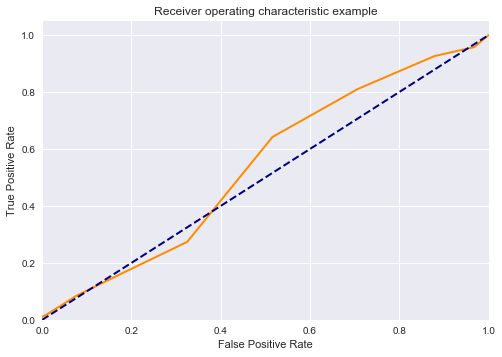

0.49296010727455586

In [185]:
def build_roc_auc(model, X_train, X_test, y_train, y_test):
    '''
    INPUT:
    model - an sklearn instantiated model
    X_train - the training data
    y_train - the training response values (must be categorical)
    X_test - the test data
    y_test - the test response values (must be categorical)
    OUTPUT:
    auc - returns auc as a float
    prints the roc curve
    '''
    import numpy as np
    import matplotlib.pyplot as plt
    from itertools import cycle
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    from scipy import interp
    
    y_preds = model.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(y_test)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_preds[:, 1])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_preds[:, 1].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.show()
    
    return roc_auc_score(y_test, np.round(y_preds[:, 1]))
    
    
# Finding roc and auc for the random forest model    
build_roc_auc(model, X_train, X_test, y_train, y_test) 

## Refinement

In [135]:
from sklearn.model_selection import GridSearchCV

In [190]:
# Parameters SVM
parameters = {'loss':['hinge', 'squared_hinge'],'C':[0.1, 1, 10]}

In [191]:
# More parameters SVM
parameters = {'C':[0.1, 1, 10], 'dual':[True, False]}

In [193]:
scorer = make_scorer(precision_score)

In [49]:
model.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

#### Refining Random Forest

In [60]:
# For random forest
model.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [62]:
# rf
parameters = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [194]:
# rf tuned
parameters = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [100, 200, 400]}

In [200]:
# rf test parameters

parameters = {'bootstrap': [True, False],
              'max_depth': [10, 20, 30],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10],
              'n_estimators': [200, 400, 600]}

In [201]:
# Create the object.
grid_obj = GridSearchCV(model, parameters, scoring=scorer)
# Fit the data
grid_fit = grid_obj.fit(X, y)

In [202]:
best_clf = grid_fit.best_estimator_

## Evaluation

In [203]:
best_pred = best_clf.predict(X_test)

In [204]:
print(precision_score(y_test, best_pred, average='weighted'))

0.914420896564


In [209]:
print(recall_score(y_test, best_pred, average='weighted'))
print(f1_score(y_test, best_pred, average='weighted'))

0.900793650794
0.896936069502


In [205]:
print(precision_score(y_test, best_pred))

1.0


In [206]:
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estimators=600, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [207]:
# save the tuned model to disk
filename = 'tuned_rf2.sav'
pickle.dump(best_clf, open(filename, 'wb'))

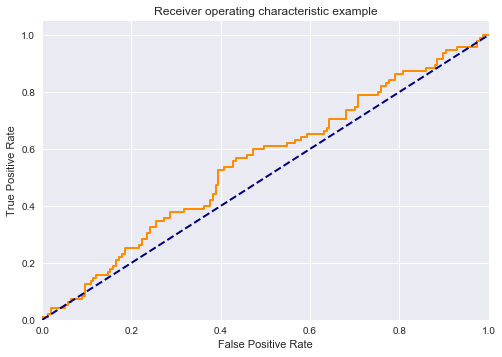

0.50083808246731476

In [208]:
build_roc_auc(best_clf, X_train, X_test, y_train, y_test) 